In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import tensorflow as tf
import keras
import tensorflow_probability as tfp
import matplotlib.pyplot as plt


2024-06-17 09:15:38.185187: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 09:15:38.234732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 09:15:38.234764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 09:15:38.235971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 09:15:38.243697: I tensorflow/core/platform/cpu_feature_guar

In [2]:
    # Distribution Settings
    scale = 1
    mean = 0

    normal_dist = scipy.stats.norm(loc=mean, scale=scale)

    # Number of independent datapoints 
    T = 1000

    seed=360
    rng = np.random.RandomState(seed)
    y_T = normal_dist.rvs(size=T, random_state=rng)

    # create keras model
    inputs = keras.Input(shape=0)
    # a dense layer with an empty input will just be an intercept term
    intercept_layer = keras.layers.Dense(1, activation = None)
    # Create a normal distribution with a mean equal to the input 
    distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))
    predicted_mean = intercept_layer(inputs)
    distribution = distribution_layer(predicted_mean)
    model = keras.Model(inputs=inputs, outputs=distribution)

2024-06-17 09:15:56.001580: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-17 09:15:56.001619: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-06-17 09:15:56.001624: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-06-17 09:15:56.001694: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-06-17 09:15:56.001722: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-06-17 09:15:56.001727: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [42]:
intercept = model.trainable_variables[1]
intercept.assign([-10])

print(f'intercept {model.get_weights()[1]}')

intercept [-10.]


In [43]:
    # Create an empty input so we can do a forward pass
    x_TF = np.zeros(shape=(T,0))


In [96]:
grads = []
vals = []
for val in np.linspace(-10,10,11):
    print(val)
    intercept = model.trainable_variables[1]
    intercept.assign([val])
    for i in range(1):
        if i%10==0:
            print(i) 
        # number of score function trick samples
        N=1000

        with tf.GradientTape() as tape, tf.GradientTape() as loss_tape:
            model_distribution = model(x_TF)
            sample_y_NT = model_distribution.sample(N)
            stopped_samples_NT = tf.stop_gradient(sample_y_NT)
            sample_log_probs_NT = model_distribution.log_prob(stopped_samples_NT)
            #estimator = tf.reduce_mean(sample_log_probs_NT*stopped_samples_NT, axis=0)
        
            sample_y_NT = model_distribution.sample(N)
            stopped_samples_NT = tf.stop_gradient(sample_y_NT)
            expected_action_T = tf.reduce_mean(sample_y_NT, axis=0)
            estimator = tf.reduce_mean(sample_log_probs_NT*tf.expand_dims(expected_action_T,axis=0), axis=0)
            loss_T = keras.losses.mean_squared_error(y_T, expected_action_T)
            #estimator = tf.reduce_mean(sample_log_probs_NT*tf.expand_dims(loss_T,axis=0), axis=0)
        action_grad = tape.jacobian(estimator, model.trainable_weights)



        other_grad = loss_tape.gradient(loss_T, expected_action_T)



        #gradients = tape.gradient(estimator, model.trainable_weights)
        grads.append(tf.reduce_mean(tf.squeeze(other_grad) * tf.squeeze(action_grad[1])))
        vals.append(val)




-10.0
0
-8.0
0
-6.0
0
-4.0
0
-2.0
0
0.0
0
2.0
0
4.0
0
6.0
0
8.0
0
10.0
0


In [92]:
tf.squeeze(action_grad)

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [1000,1,0,1] != values[1].shape = [1000,1,1] [Op:Pack] name: packed

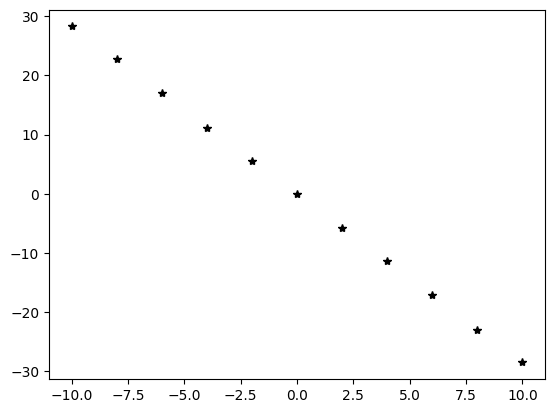

In [97]:
plt.plot(vals, grads,'k*')

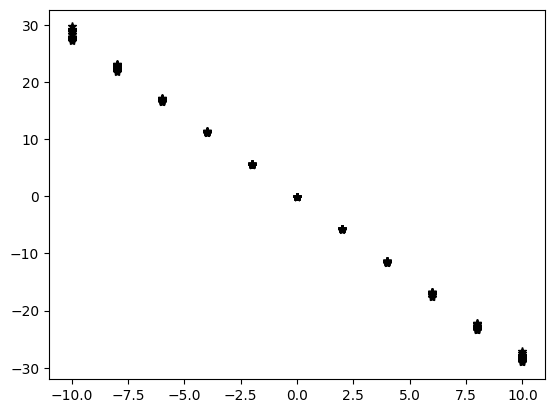

In [94]:
plt.plot(vals, grads,'k*')

In [130]:
    # number of score function trick samples
    N=1000
    accumulated_gradients = tf.zeros_like(model.trainable_weights[1])
    for sample in range(N):
        if sample % 100 == 0:
            print(f'sample {sample}')
        with tf.GradientTape() as tape:
            model_distribution = model(x_TF)
            sample_y_T = model_distribution.sample()
            stopped_samples = tf.stop_gradient(sample_y_T)
            sample_log_probs_T = model_distribution.log_prob(stopped_samples)

        # get gradient of 1 sample
        gradients_T = tape.jacobian(sample_log_probs_T, model.trainable_weights)
        accumulated_gradients = accumulated_gradients + tf.squeeze(gradients_T[1])*tf.squeeze(sample_y_T)
    grads = accumulated_gradients/N


sample 0
sample 100
sample 200
sample 300
sample 400
sample 500
sample 600
sample 700
sample 800
sample 900


In [131]:
grads

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([ 3.6003740e+00, -2.3771672e+00, -1.9957986e+00, -8.3994791e-02,
       -3.9771090e+00,  2.5410318e+00, -2.0656660e+00, -3.0712757e-01,
       -1.4202669e+00,  4.4120317e+00, -6.1552656e-01,  5.7478719e+00,
       -3.1345863e+00,  4.3894207e-01,  2.5630693e+00, -1.7205009e-02,
        1.0654670e+00, -2.9456079e+00,  4.9216061e+00,  7.1745110e-01,
        4.5025001e+00,  2.2763243e+00,  3.6486821e+00,  3.1093928e-01,
        1.4824314e+00,  3.0262682e+00, -6.3945276e-01,  5.2905428e-01,
        3.6071281e+00,  1.7098497e+00,  1.9117434e+00,  1.6612194e+00,
       -4.2635446e+00,  1.1696279e+00,  3.6705059e-01,  1.6989952e+00,
       -1.2992285e-01,  2.0942252e+00,  4.0593877e+00, -6.7372066e-01,
       -3.2059159e+00,  3.0804186e+00,  3.7859890e-01,  2.5868933e+00,
        4.9837804e+00, -5.7443418e-02,  1.0561616e+00,  1.8867499e-01,
       -2.7102661e+00,  6.7626476e-01,  4.1810756e+00,  3.6669856e-01,
       -2.7232280e+00,  4.83

In [132]:
tf.reduce_mean(grads)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0250018>

(array([  2.,  12.,  54., 132., 226., 256., 175., 100.,  34.,   9.]),
 array([-9.93374062, -7.87193441, -5.81012774, -3.74832153, -1.68651509,
         0.37529135,  2.43709779,  4.49890423,  6.56071043,  8.62251663,
        10.68432331]),
 <BarContainer object of 10 artists>)

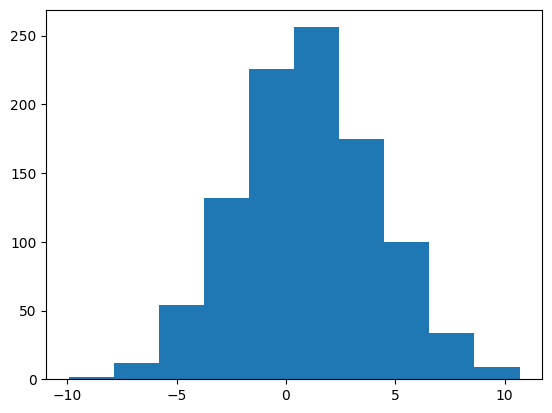

In [133]:
plt.hist(grads)

In [66]:
grads

[<tf.Tensor: shape=(0, 1), dtype=float32, numpy=array([], shape=(0, 1), dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.30156586], dtype=float32)>]

In [31]:
y_T

array([ 7.05285352e-01, -3.54907176e-03, -1.07646333e+00, -1.91435298e+00,
       -1.15810104e+00,  5.94416360e-01, -5.82006933e-01,  1.75714964e-01,
        9.31664812e-01,  1.70783614e-01, -3.86702699e-01, -8.81647514e-01,
        4.65897797e-02, -6.42763396e-01, -9.72790851e-01, -7.12514214e-02,
       -9.30796717e-01,  1.17586309e+00, -1.42657680e+00, -1.29948714e-01,
        2.48938484e+00, -1.56076711e-01, -1.09153038e+00,  7.02537911e-01,
        3.69613948e-01,  3.60063862e-01, -5.80114630e-01, -2.33434629e+00,
       -1.02928805e+00, -1.14843750e+00,  1.74841572e+00, -8.33791759e-01,
        1.04447877e+00,  5.21775756e-01, -2.16027191e-01, -1.24339112e+00,
       -5.59799342e-02,  1.66437522e+00, -1.18742686e+00, -4.95992944e-02,
       -2.83716646e-01, -4.22152148e-01, -2.96166814e+00,  6.17989584e-01,
       -1.51268025e+00,  1.06160901e+00,  4.28447624e-01,  4.08640649e-01,
       -9.10483558e-01,  1.22710597e-01,  5.28330232e-01,  2.93015523e-01,
       -7.17089806e-01,  